In [29]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib #
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D


# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


In [15]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_2d_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, condition = None, number = None,
                           x = None, y = None,
                           xrange = None, y_value = None, y_error = None,
                           validation_frac = None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (x == None) or (y == None): 
            raise Warning(f'$X$ and $Y$ must be given')
        
        if (validation_frac == None):
            warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
            validation_frac = 0.2
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        columns = x + y
        
        print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = []
            df0 = self.get_data_of_a_track(filename = filename, x = x, y = y, y_value = y_value, y_error = y_error)
            df1.append(df0)
            
        df = pd.concat(df1, ignore_index=True)
        
        random_state = 1

        if (len(df['type'])*(1 - validation_frac) >= 10000):
            train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        else:
            train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, x = None, 
                            y = None, y_value = None, y_error = None):
        '''
        '''        
        columns = x + y
        one_track = []
        one_track = pd.read_csv(filename)
        
        one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
        
        #get rid of the pre-MS
        one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        one_track['type'] = 'vali'
        
        one_track = one_track.loc[((one_track['frac_age'] >= 0.85) &
                                   (one_track['frac_age'] <= 0.95) &
                                   (one_track['star_mass'] <= 1.03) & 
                                   (one_track['star_mass'] >= 0.97)
                                  )]
        
        if ((y_value != None) & (y_error != None) & (one_track.shape[0]>=10)): 
            for i in range(len(y)):
                yrange = [(y_value[i] - y_error[i]), (y_value[i] + y_error[i]) ]
                temp = None
                temp = one_track[(one_track[y[i]] >= min(yrange)) & (one_track[y[i]] <= max(yrange))]
                if (temp.shape[0] >= 10):
                    one_track = one_track.loc[temp.index.min(): temp.index.max()]
                else:
                    one_track = None
                    break
        
        return one_track
    
    #############################################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    


# global_kernel 

The global_kernel class is to find proper GP kernels for global stellar parameters (e.g. Teff, Radius) and resample them as a function of the age. 

A recomended step-by-step procudure for a stellar parameter is: 
1. 'global_kernel.preview_1d_data'：preview data with to see which kernels could be used;  
2. 'global_kernel.generate_kernel_grid' or manually: set up a list of kernels 
3. 'global_kernel.find_1d_kernel': find the best kernel for a certain parameter with a random selected subset in the grid
4. 'global_kernel.gpmodel': use the kernel found in step 3 and obtain one gp model for each global parameter on each track (as a function of stellar age) 
5. 'global_kernel.resample': resample each evolutaionary track  


# set up path

In [16]:
datadr = '/Users/litz/Documents/GitHub/data/subset_feh_multiple/'
savedr = '/Users/litz/Documents/GitHub/GPflow/3D-teff/'


In [17]:
g2 = global_2d_kernel()
g2.set_path(datapath = datadr, savepath = savedr)


Data path is set as/Users/litz/Documents/GitHub/data/subset_feh_multiple/
Save path is set as/Users/litz/Documents/GitHub/GPflow/3D-teff/


# here we model the sun with GP -3D 
# 1st we first get model points in a grid

In [18]:
fundimential = ['star_mass', 'frac_age','star_age', 'initial_feh']
fundimential_value = []

observable = ['effective_T' , 'log_g']
observable_value = [5777.0, 4.44]
observable_error = [250.0, 0.1]


df = g2.get_data_of_a_grid(condition = '*.csv', number = None,
                           x = fundimential, y = observable,
                           xrange = None, 
                           y_value = None, #observable_value, 
                           y_error = None, #observable_error,
                           validation_frac = 0.3)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: $number$ is missing, all file will be used


399 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


# the model points are as below

In [19]:
df


,star_mass,frac_age,star_age,initial_feh,effective_T,log_g,type
0,0.99,0.850958,9.970414e+09,0.0,5832.564033,4.161977,vali
1,0.99,0.854243,1.000891e+10,0.0,5827.515664,4.157319,data
2,0.99,0.857422,1.004616e+10,0.0,5822.336276,4.152697,vali
3,0.99,0.860495,1.008216e+10,0.0,5817.019151,4.148116,data
4,0.99,0.863461,1.011692e+10,0.0,5811.622674,4.143590,data
...,...,...,...,...,...,...,...
11496,0.97,0.948561,8.801139e+09,-4.0,5506.919479,3.823424,data
11497,0.97,0.948917,8.804443e+09,-4.0,5499.148397,3.821303,data
11498,0.97,0.949270,8.807716e+09,-4.0,5491.404235,3.819184,data
11499,0.97,0.949619,8.810959e+09,-4.0,5483.682367,3.817069,data


# 2nd we GP one observed parameter -- Teff = f(mass, age, feh)

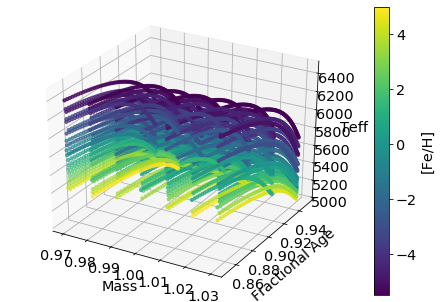

In [20]:
fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(df['star_mass'], df['frac_age'], df['effective_T'], s=10, c=df['initial_feh'])
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([5000,6500])
char = plt.colorbar(cp)
char.set_label('[Fe/H]')

# now we prepare the data and use GP to train teff = f(mass, age, FeH)

In [21]:
x1 = df['star_mass'][df['type'] == 'data'].to_numpy()
x2 = df['frac_age'][df['type'] == 'data'].to_numpy()
x3 = df['initial_feh'][df['type'] == 'data'].to_numpy()

z = df['effective_T'][df['type'] == 'data'].to_numpy().reshape(-1, 1)

x1.size

8051

In [22]:
x1_v = df['star_mass'][df['type'] == 'vali'].to_numpy()
x2_v = df['frac_age'][df['type'] == 'vali'].to_numpy()
x3_v = df['initial_feh'][df['type'] == 'vali'].to_numpy()

z_v = df['effective_T'][df['type'] == 'vali'].to_numpy().reshape(-1, 1)

x1_v.size

3450

# we use matern12 to train teff becasue this is the best kernel in 1D GP (teff = f(age))

In [23]:
# had to set this 
# to avoid the following error
# tensorflow.python.framework.errors_impl.InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]
gpflow.config.set_default_positive_minimum(1e-6)

# setup the kernel

k = gpflow.kernels.Matern12()


# set up GPR model

# I think the shape of the independent data
# should be (400, 2) for this case
xx = np.column_stack([[x1, x2, x3]]).T
xx_v = np.column_stack([[x1_v, x2_v, x3_v]]).T

print(xx.shape, xx_v.shape) # this will be (400, 2)



(8051, 3) (3450, 3)


In [24]:
m_teff = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

# optimise hyper-parameters
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m_teff.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m_teff.trainable_variables,
                        options=dict(maxiter=100)
                       )


In [25]:
# predict training set
mean, var = m_teff.predict_f(xx)

mean_v, var_v = m_teff.predict_f(xx_v)

# this trainning includes ~8000 data points and takes hours
# Now we have a GP prediction for the training data. As shown below, many GP data do not well fit validation data.

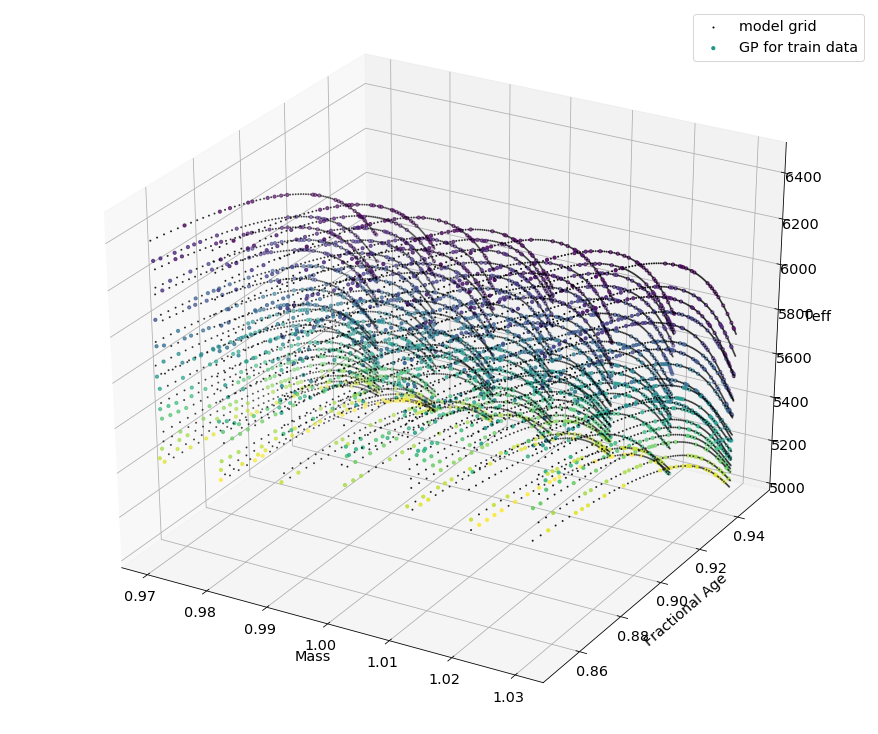

In [30]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, z, s=1, c='k', label = 'model grid')
ax.scatter(x1_v, x2_v, mean_v, s=10, c= x3_v, label = 'GP for train data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([5000,6500])
ax.legend()

# we also reserve ~2000 data points for validation. The polt below is to demostrate the differences between GP and real data. The agreement of validation data (red) is not as good as that of training data (blue). We nextly investigate the situation of each layer. 

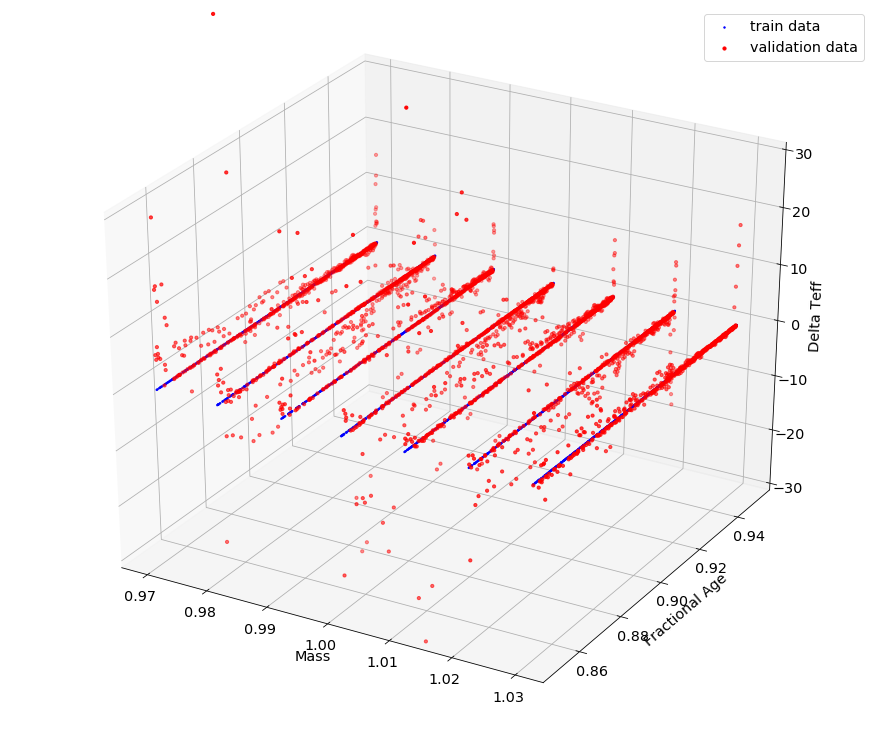

In [34]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, mean - z, s=2, c='b', label = 'train data')
ax.scatter(x1_v, x2_v, mean_v - z_v, s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-30,30])
ax.legend()

# we inspect the middle layer (feh = 0.0), which looks very nice.

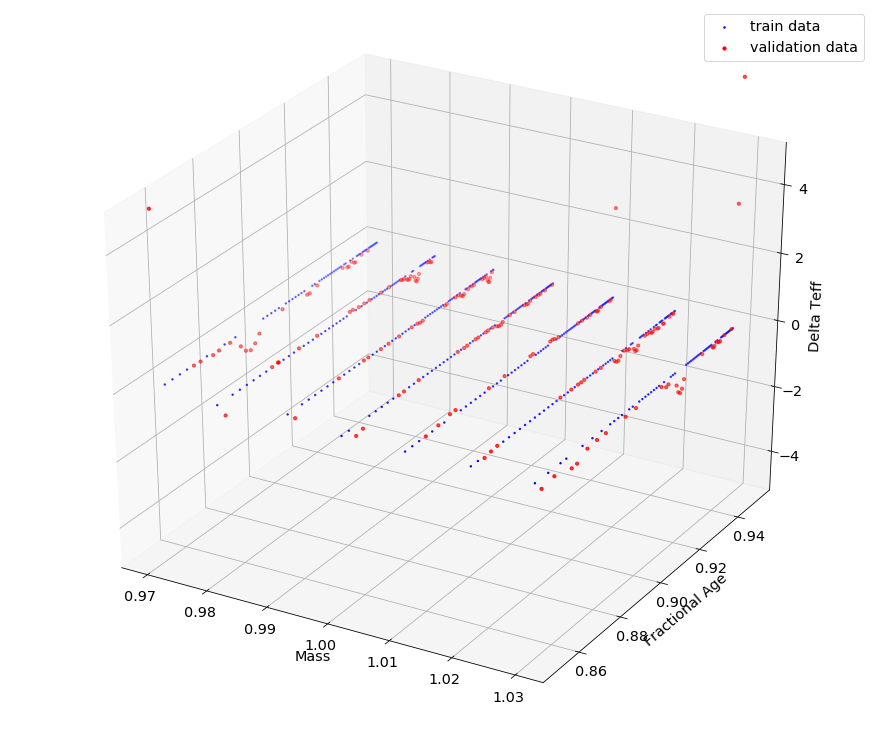

In [35]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (x3 == 0.0) 
nuse_v = (x3_v == 0.0)

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-5,5])
ax.legend()

# we inspect the center layers (feh = ±0.5), which looks very nice.

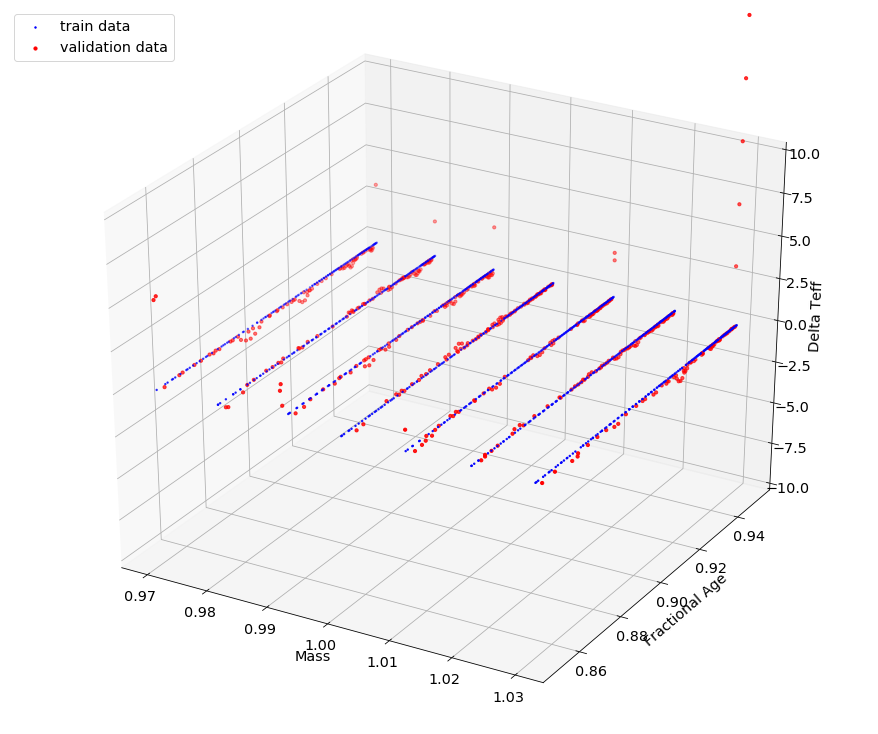

In [41]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (np.abs(x3) <= 0.5)
nuse_v = (np.abs(x3_v) <= 0.5)

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-10,10])
ax.legend()

# we inspect the inner layers (feh = ±1.0), where many points are off up to 50K

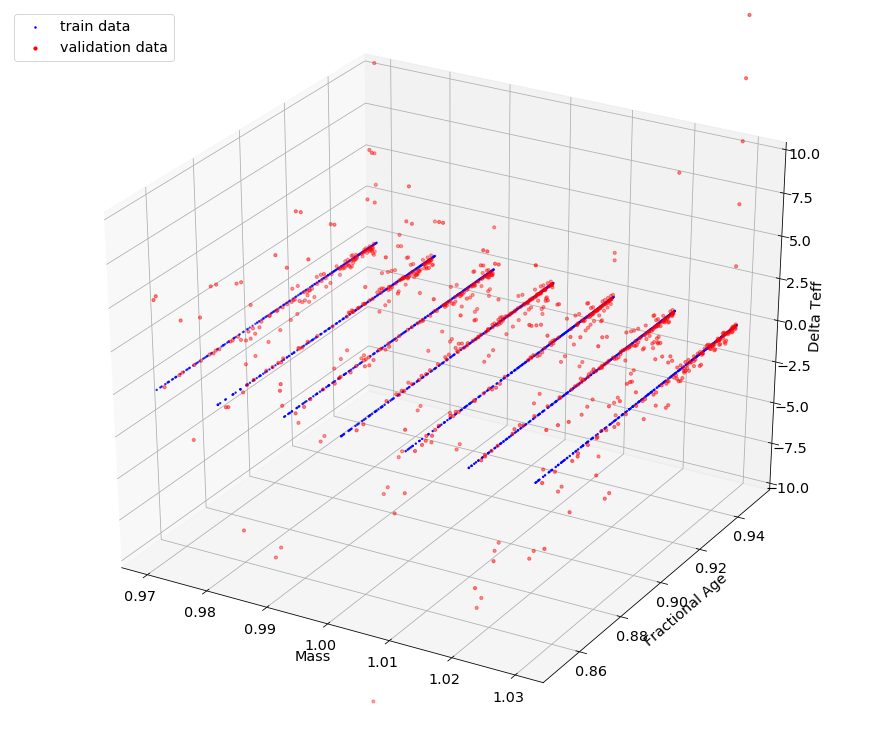

In [42]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (np.abs(x3) <= 1.)
nuse_v = (np.abs(x3_v) <= 1.)

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-10,10])
ax.legend()

# we inspect the outter layers (feh = 2.0), as bad as above.

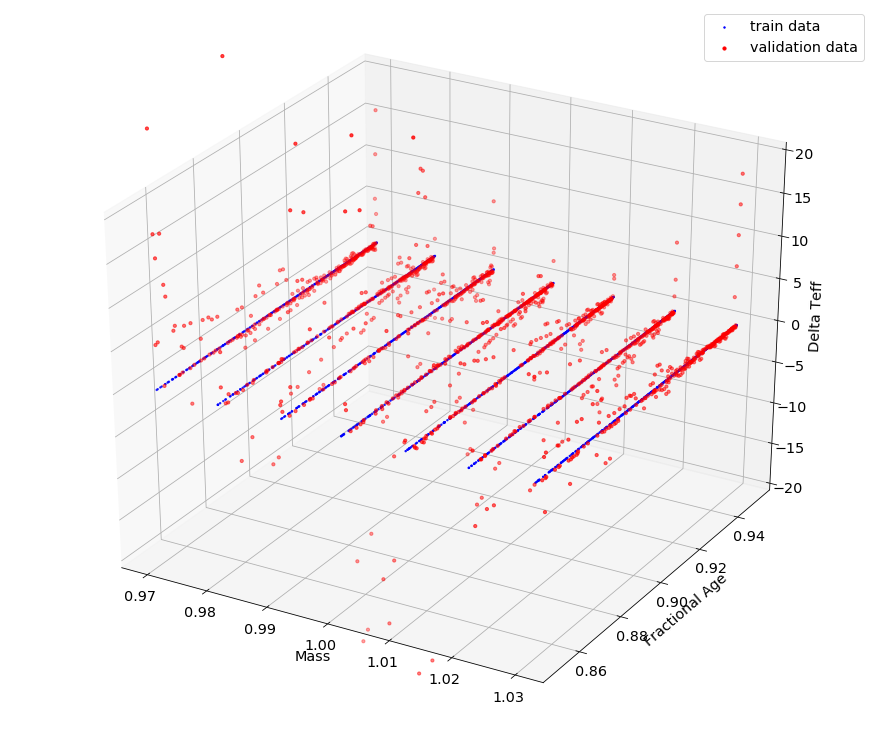

In [44]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (np.abs(x3) - 2.) <= 0.01
nuse_v = (np.abs(x3_v) - 2.) <=0.01

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-20,20])
ax.legend()

# we inspect the outter layers (feh = 3.0), as bad as above.

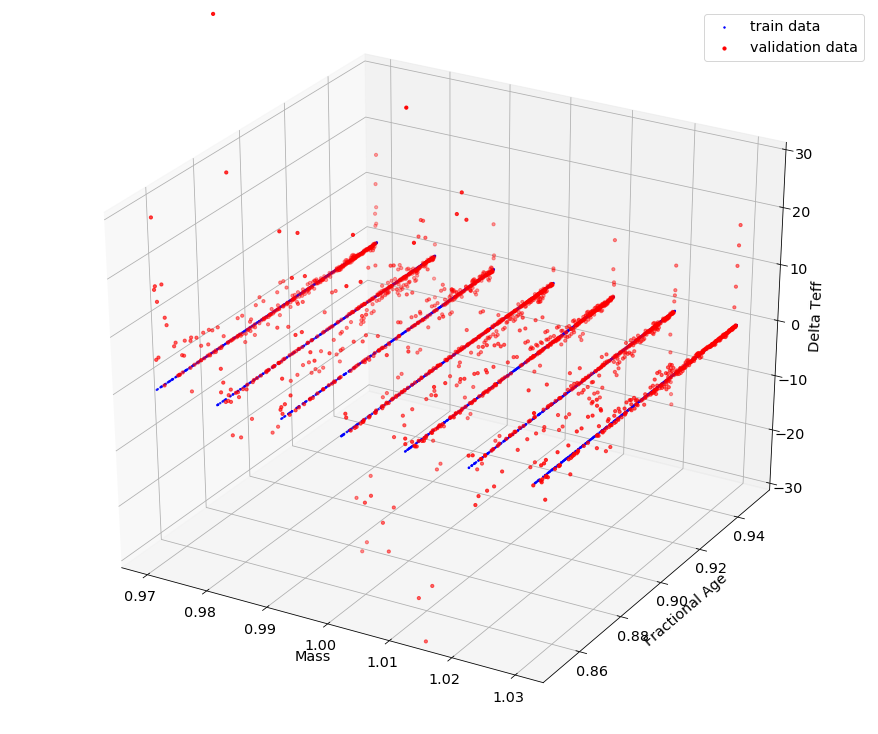

In [45]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (np.abs(x3) - 3) <= 0.01
nuse_v = (np.abs(x3_v) - 3) <=0.01

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-30,30])
ax.legend()

# we inspect the outter layers (feh = 4.0), as bad as above.

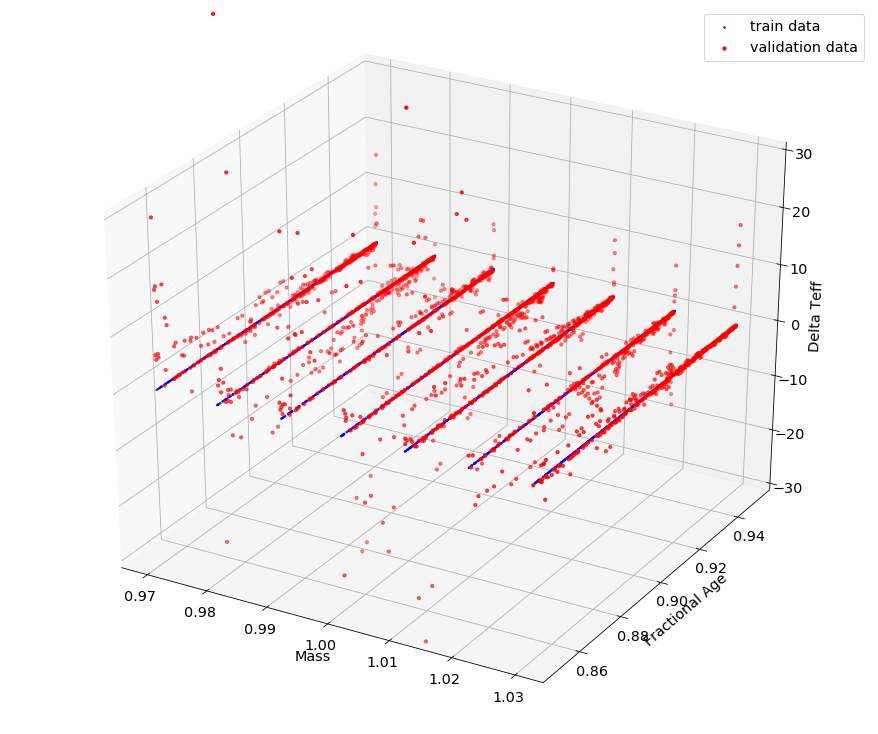

In [46]:
fig = plt.figure()
ax = Axes3D(fig)

nuse = (np.abs(x3) - 4) <= 0.01
nuse_v = (np.abs(x3_v) - 4) <=0.01

ax.scatter(x1[nuse], x2[nuse], mean[nuse] - z[nuse], s=2, c='b', label = 'train data')
ax.scatter(x1_v[nuse_v], x2_v[nuse_v], mean_v[nuse_v] - z_v[nuse_v], s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta Teff')
ax.set_zlim([-30,30])
ax.legend()

# Now we start training logg = f(mass, age, FeH)

In [48]:
z = df['log_g'][df['type'] == 'data'].to_numpy().reshape(-1, 1)
z_v = df['log_g'][df['type'] == 'vali'].to_numpy().reshape(-1, 1)




In [49]:
m_logg = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

# optimise hyper-parameters
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m_logg.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m_logg.trainable_variables,
                        options=dict(maxiter=100)
                       )



In [50]:
# predict training set
mean, var = m_logg.predict_f(xx)

mean_v, var_v = m_logg.predict_f(xx_v)

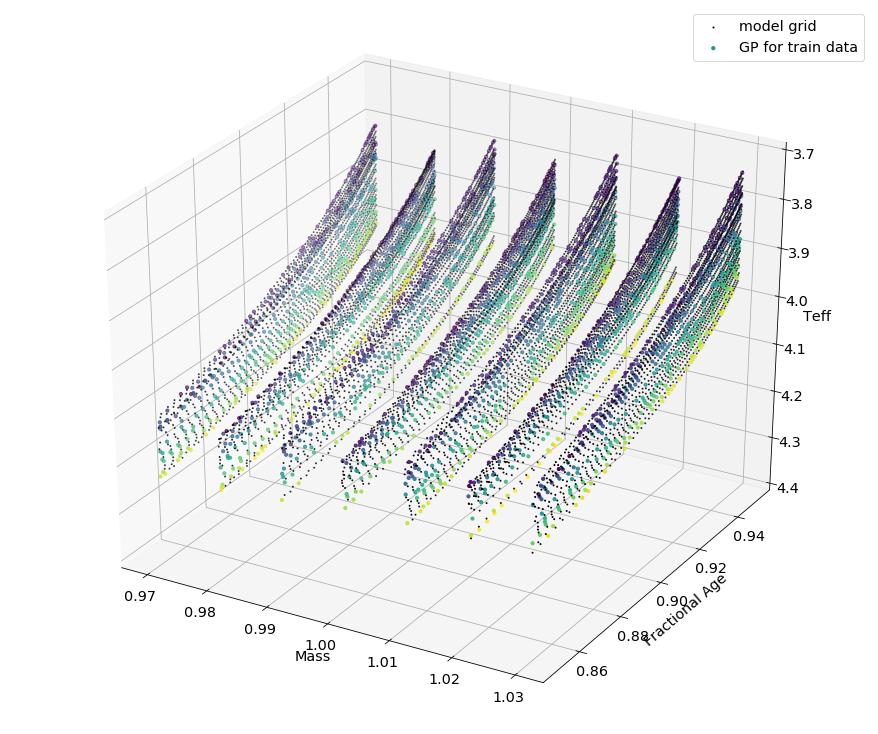

In [54]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, z, s=1, c='k', label = 'model grid')
ax.scatter(x1_v, x2_v, mean_v, s=10, c= x3_v, label = 'GP for train data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([4.4,3.7])
ax.legend()

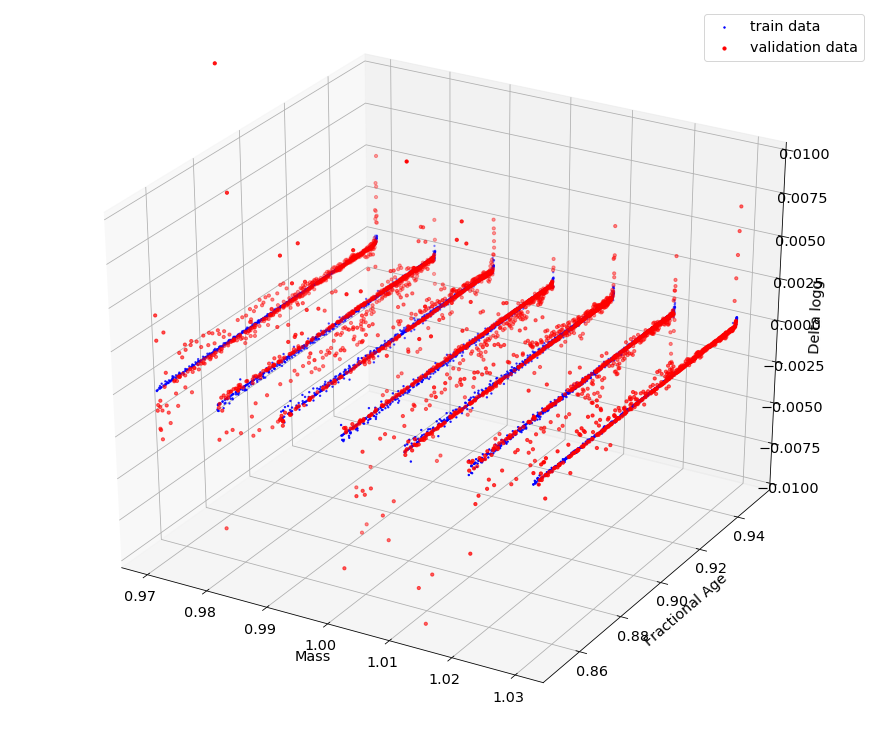

In [61]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, mean - z, s=2, c='b', label = 'train data')
ax.scatter(x1_v, x2_v, mean_v - z_v, s=10, c='r', label = 'validation data')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Delta logg')
ax.set_zlim([-.01,.01])
ax.legend()

# 3rd Now we make a GP Teff-logg diagram and compare it with the model grid

In [74]:
x1_new = np.random.uniform(0.97,1.03,10000)
x2_new = np.random.uniform(0.85,0.95,10000)
x3_new = x2_new*0.0 + 0.0

xx_new = np.column_stack([[x1_new, x2_new, x3_new]]).T

gpteff, gpteff_var = m_teff.predict_f(xx_new)
gplogg, gplogg_var = m_logg.predict_f(xx_new)

# Look at that, GP generates a non-sparse 'map'.

(4.2, 3.8)

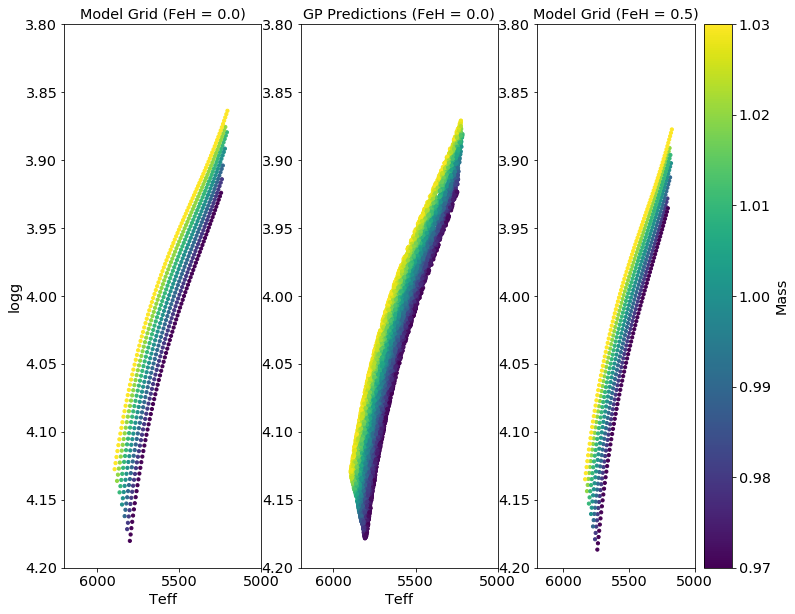

In [76]:
fig, (ax, ax2, ax3) = plt.subplots(1,3)
cp = ax.scatter(df['effective_T'][df['initial_feh'] == 0.0], df['log_g'][df['initial_feh'] == 0.0],
                c = df['star_mass'][df['initial_feh'] == 0.0], s = 10)
ax.set_title('Model Grid (FeH = 0.0)')
ax.set_xlabel('Teff')
ax.set_ylabel('logg')
ax.set_xlim([6200,5000])
ax.set_ylim([4.2,3.8])
char = plt.colorbar(cp)
char.set_label('Mass')

ax3.scatter(df['effective_T'][df['initial_feh'] == 0.5], df['log_g'][df['initial_feh'] == 0.5],
                c = df['star_mass'][df['initial_feh'] == 0.5], s = 10)
ax3.set_title('Model Grid (FeH = 0.5)')
ax3.set_xlim([6200,5000])
ax3.set_ylim([4.2,3.8])

gpmass = x1_new.reshape(-1,1)

cp2 = ax2.scatter(gpteff, gplogg, c = gpmass, s = 10)
ax2.set_title('GP Predictions (FeH = 0.0)')
ax2.set_xlabel('Teff')
ax2.set_xlim([6200,5000])
ax2.set_ylim([4.2,3.8])

In [77]:
x1_new = np.random.uniform(0.97,1.03,10000)
x2_new = np.random.uniform(0.85,0.95,10000)
x3_new = x2_new*0.0 + 0.3

xx_new = np.column_stack([[x1_new, x2_new, x3_new]]).T

gpteff, gpteff_var = m_teff.predict_f(xx_new)
gplogg, gplogg_var = m_logg.predict_f(xx_new)

(4.2, 3.8)

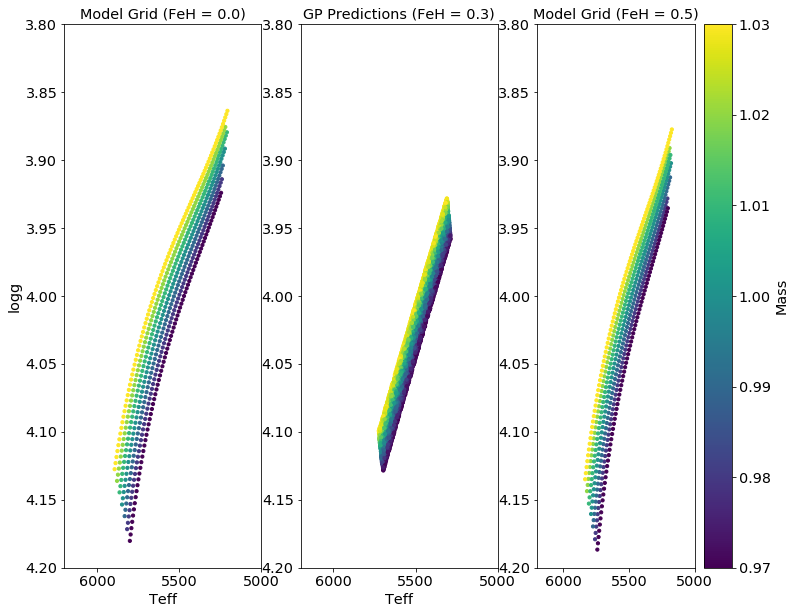

In [78]:
fig, (ax, ax2, ax3) = plt.subplots(1,3)
cp = ax.scatter(df['effective_T'][df['initial_feh'] == 0.0], df['log_g'][df['initial_feh'] == 0.0],
                c = df['star_mass'][df['initial_feh'] == 0.0], s = 10)
ax.set_title('Model Grid (FeH = 0.0)')
ax.set_xlabel('Teff')
ax.set_ylabel('logg')
ax.set_xlim([6200,5000])
ax.set_ylim([4.2,3.8])
char = plt.colorbar(cp)
char.set_label('Mass')

ax3.scatter(df['effective_T'][df['initial_feh'] == 0.5], df['log_g'][df['initial_feh'] == 0.5],
                c = df['star_mass'][df['initial_feh'] == 0.5], s = 10)
ax3.set_title('Model Grid (FeH = 0.5)')
ax3.set_xlim([6200,5000])
ax3.set_ylim([4.2,3.8])

gpmass = x1_new.reshape(-1,1)

cp2 = ax2.scatter(gpteff, gplogg, c = gpmass, s = 10)
ax2.set_title('GP Predictions (FeH = 0.3)')
ax2.set_xlabel('Teff')
ax2.set_xlim([6200,5000])
ax2.set_ylim([4.2,3.8])

(4.2, 3.8)

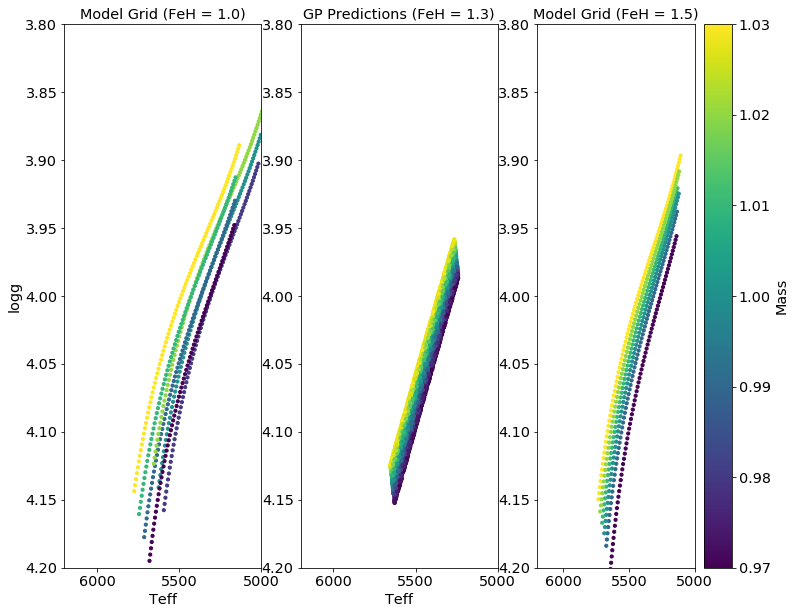

In [80]:
x1_new = np.random.uniform(0.97,1.03,10000)
x2_new = np.random.uniform(0.85,0.95,10000)
x3_new = x2_new*0.0 + 1.3

xx_new = np.column_stack([[x1_new, x2_new, x3_new]]).T

gpteff, gpteff_var = m_teff.predict_f(xx_new)
gplogg, gplogg_var = m_logg.predict_f(xx_new)

fig, (ax, ax2, ax3) = plt.subplots(1,3)
cp = ax.scatter(df['effective_T'][df['initial_feh'] == 1.0], df['log_g'][df['initial_feh'] == 1.0],
                c = df['star_mass'][df['initial_feh'] == 1.0], s = 10)
ax.set_title('Model Grid (FeH = 1.0)')
ax.set_xlabel('Teff')
ax.set_ylabel('logg')
ax.set_xlim([6200,5000])
ax.set_ylim([4.2,3.8])
char = plt.colorbar(cp)
char.set_label('Mass')

ax3.scatter(df['effective_T'][df['initial_feh'] == 1.5], df['log_g'][df['initial_feh'] == 1.5],
                c = df['star_mass'][df['initial_feh'] == 1.5], s = 10)
ax3.set_title('Model Grid (FeH = 1.5)')
ax3.set_xlim([6200,5000])
ax3.set_ylim([4.2,3.8])

gpmass = x1_new.reshape(-1,1)

cp2 = ax2.scatter(gpteff, gplogg, c = gpmass, s = 10)
ax2.set_title('GP Predictions (FeH = 1.3)')
ax2.set_xlabel('Teff')
ax2.set_xlim([6200,5000])
ax2.set_ylim([4.2,3.8])

# 4th use MCMC to model the Sun with GP predictions ...